# **Project: Loan Default Prediction**  
This project aims to predict loan defaults using machine learning, based on the steps outlined in the PDF.

# **1. Data Loading and Initial Inspection**

**Explanation**  
Data Loading: This loads the dataset and shows the first few rows for a quick look.  
Basic Structure: df.info() helps identify data types and any columns with missing values, a key step in preparing data.

In [60]:
# Import essential libraries
import pandas as pd
import numpy as np

# Load the dataset - replace 'file_path' with your actual path to the CSV file
file_path = 'C:/Users/leo/Downloads/Loan_status_2007-2020Q3-100ksample (1).csv'
df = pd.read_csv(file_path)

# Display the first few rows and structure of the data
print(df.head())       # Preview first few rows
print(df.info())       # Check for data types and missing values



   Unnamed: 0.1  Unnamed: 0         id  loan_amnt  funded_amnt  \
0       1746494       25450  167338079     4000.0       4000.0   
1       2370717       81861   71016917    24000.0      24000.0   
2       2264870      397109   39589826     5000.0       5000.0   
3        595422       15492  134798709    24000.0      24000.0   
4        562657       90591  127097355    14000.0      14000.0   

   funded_amnt_inv        term int_rate  installment grade  ...  \
0           4000.0   36 months   13.08%       134.93     B  ...   
1          24000.0   60 months    9.16%       500.07     B  ...   
2           5000.0   36 months   10.49%       162.49     B  ...   
3          24000.0   60 months   11.05%       522.42     B  ...   
4          14000.0   60 months   13.59%       322.79     C  ...   

  hardship_start_date hardship_end_date payment_plan_start_date  \
0                 NaN               NaN                     NaN   
1                 NaN               NaN                     NaN   

#  **2. Data Cleaning**

**Steps and Code**  
**Drop Unnecessary Columns**: Remove any irrelevant columns, like unnamed indexes.  
**Handle Missing Values**: Drop columns with too many missing values and impute (fill in) remaining gaps.

**Explanation**  
Dropping Columns: Removes columns that don’t add value (e.g., unnamed indexes).  
Handling Missing Values: Drops columns with excessive missing data and fills gaps in numerical columns using the median value.  

In [61]:
# Drop unnecessary columns like index columns (e.g., Unnamed columns)
df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors='ignore')

# Drop columns with more than 90% missing values
missing_threshold = 0.9 * len(df)
cols_to_drop = [col for col in df.columns if df[col].isnull().sum() > missing_threshold]
df = df.drop(columns=cols_to_drop)

# Impute missing values for numerical columns with the median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Convert percentage columns to float (e.g., 'int_rate')
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float) / 100

# **3. Exploratory Data Analysis (EDA)**

**Explanation**  
**Target Analysis**: Shows if the data is balanced (equal default vs non-default).  
**Feature Distributions**: Histograms help understand numerical features and identify skewness or outliers.  
**Correlation Analysis**: Identifies features with high correlation to the target (loan_default), which may be important for the model.  

In [62]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


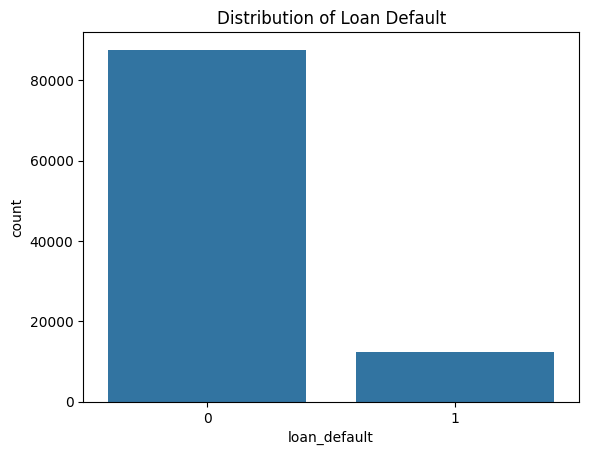

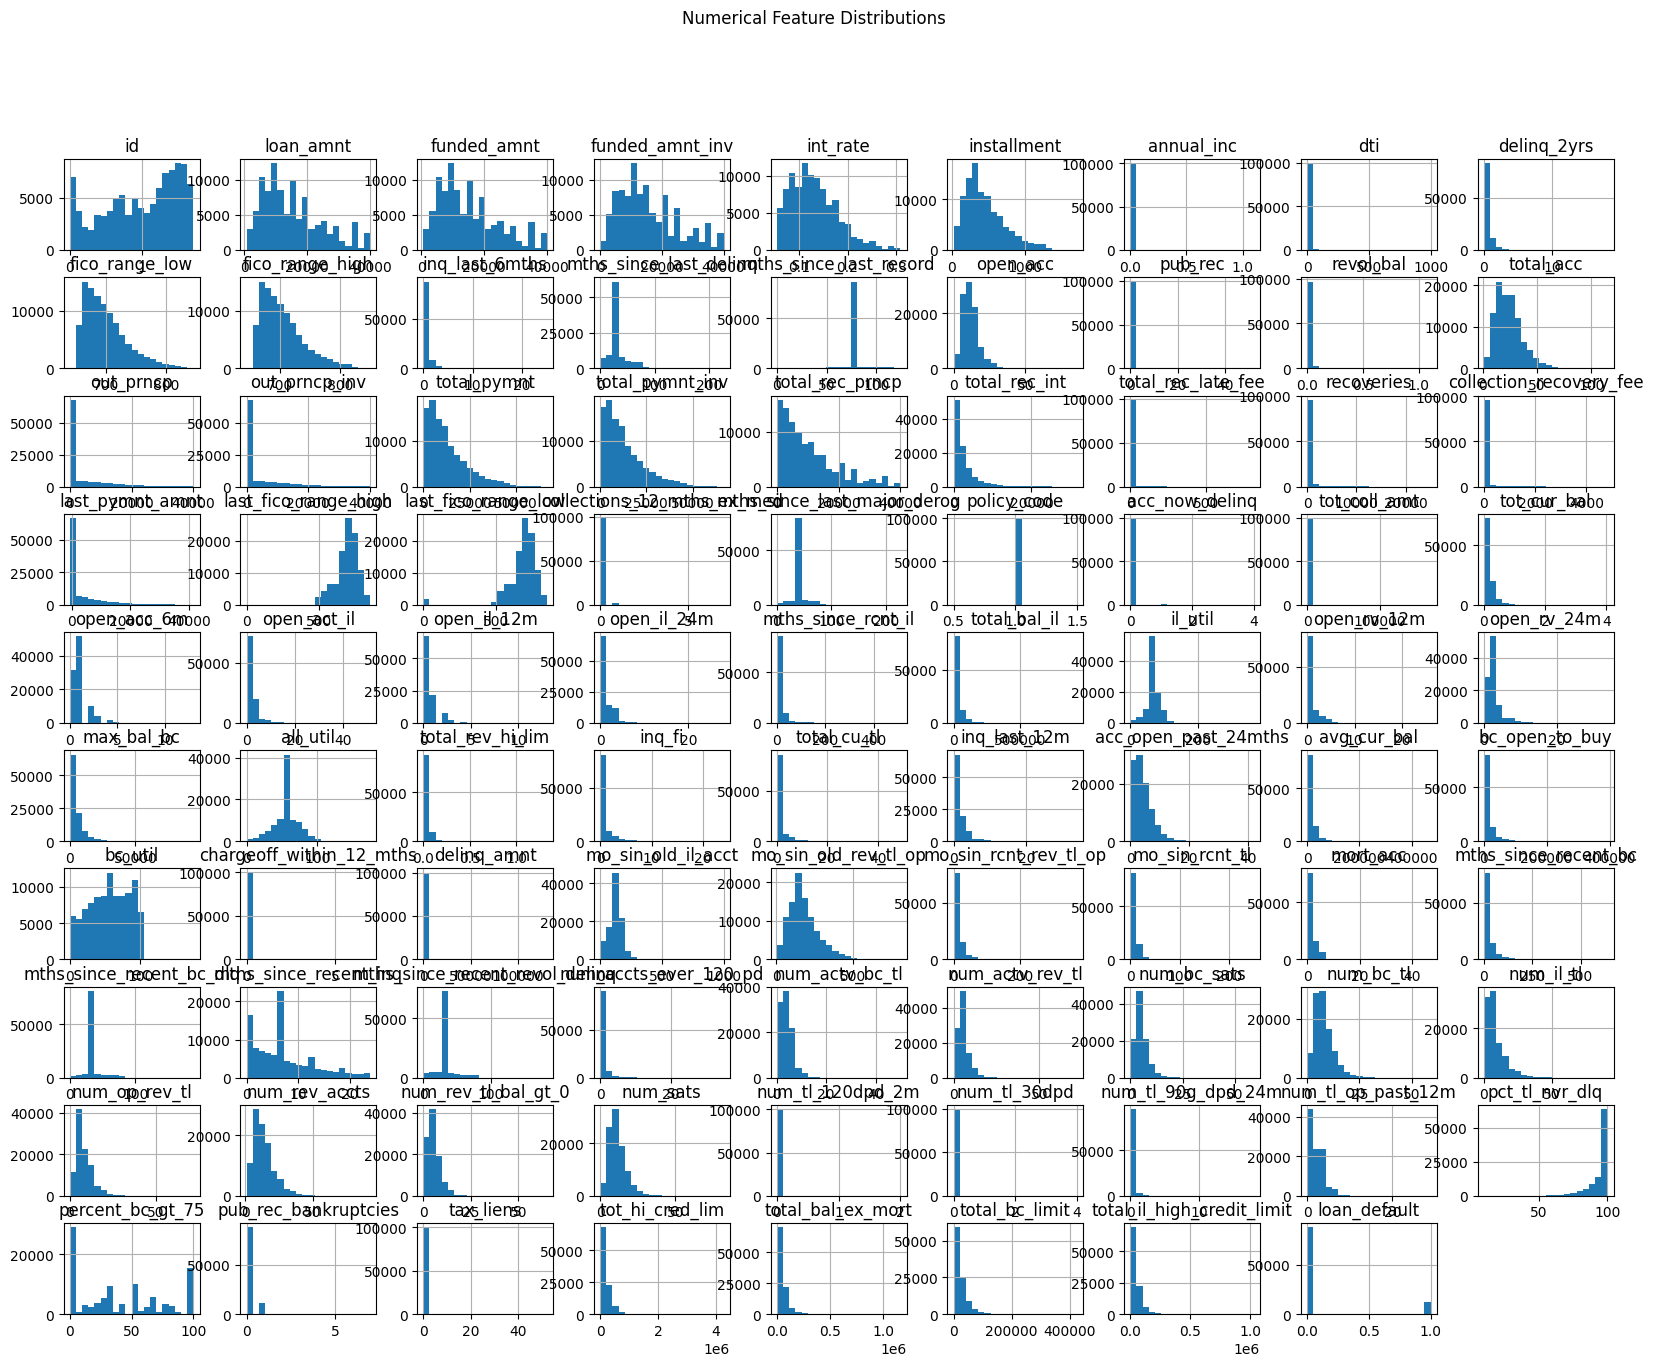

Correlations with Loan Default:
 loan_default               1.000000
recoveries                 0.549362
collection_recovery_fee    0.529699
int_rate                   0.200171
total_rec_late_fee         0.111064
                             ...   
out_prncp                 -0.203058
total_rec_prncp           -0.229884
last_fico_range_low       -0.558751
last_fico_range_high      -0.606312
policy_code                     NaN
Name: loan_default, Length: 90, dtype: float64


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Convert `loan_status` to a binary target `loan_default` if necessary
# This assumes "Charged Off" indicates default and others indicate non-default
df['loan_default'] = df['loan_status'].apply(lambda x: 1 if x == "Charged Off" else 0)

# Target variable distribution
sns.countplot(x='loan_default', data=df)
plt.title('Distribution of Loan Default')
plt.show()

# Histograms of key numerical features
df.select_dtypes(include=[np.number]).hist(bins=20, figsize=(20, 15))
plt.suptitle('Numerical Feature Distributions')
plt.show()

# Step 1: Convert "term" column from strings like "36 months" to a numeric value
df['term'] = df['term'].str.extract(r'(\d+)').astype(float)

# Step 2: Identify and exclude other non-numeric columns that may still contain text
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Step 3: Re-run the correlation calculation
correlations = numeric_df.corr()['loan_default'].sort_values(ascending=False)
print("Correlations with Loan Default:\n", correlations)

# **4. Feature Engineering**

**Explanation**  
**Feature Engineering**: Adds derived features to capture important patterns, like loan affordability (income-to-loan ratio).  
**Encoding Categorical Variables**: Converts text-based categories into numeric format, suitable for modelling.

In [64]:
# 1. Income-to-Loan Ratio
df['income_to_loan_ratio'] = df['annual_inc'] / (df['loan_amnt'] + 1)

# 2. Extract Year and Month from 'issue_d' date
# Ensure 'issue_d' is in datetime format, then extract year and month
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

# 3. One-hot encode categorical columns like 'purpose'
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)


C:\Users\leo\AppData\Local\Temp\ipykernel_8112\2672755708.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')


# **5. Model Building and Hyperparameter Tuning**

#  **Explanation**  
**Class Balancing with SMOTE**: Generates synthetic samples to handle class imbalance.  
**Hyperparameter Tuning**: GridSearchCV tests different parameter combinations to find the best model settings.  

In [65]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint

# Assuming df is your DataFrame
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns

# Reduce the number of unique categories for columns with many unique values
for col in non_numeric_columns:
    if df[col].nunique() > 100:  # Adjust the threshold as needed
        top_categories = df[col].value_counts().nlargest(100).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')

# Use label encoding for non-numeric columns
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Drop rows with NaN values
df = df.dropna()

# Use a smaller subset of the data for hyperparameter tuning
df_sample = df.sample(frac=0.1, random_state=42)

# Split data into features (X) and target (y)
X = df_sample.drop(columns=['loan_default', 'issue_d'])  # Drop 'issue_d' as it's now redundant
y = df_sample['loan_default']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the Random Forest model and parameter grid for tuning
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 2)
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2, verbose=2, random_state=42)
random_search.fit(X_train_res, y_train_res)

# Get the best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 114}


In [68]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 6. **Model Evaluation and Feature Importance**  

**Explanation**  
**Model Evaluation:** Evaluates precision, recall, and ROC AUC to assess model performance.  
**Feature Importance:** Identifies which features contribute most to the model’s predictions, providing insight into key factors driving defaults.  

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 114}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26285
           1       1.00      1.00      1.00      3715

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 1.0


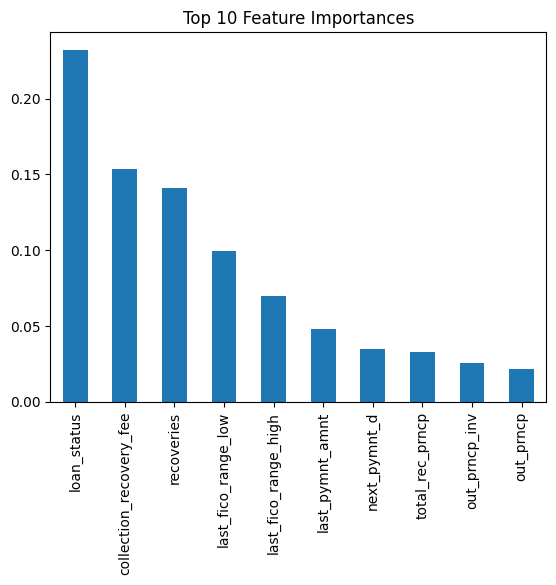

Top Correlated Features with Loan Default:
loan_default               1.000000
recoveries                 0.549362
collection_recovery_fee    0.529699
debt_settlement_flag       0.353989
next_pymnt_d               0.273404
sub_grade                  0.241445
grade                      0.237012
int_rate                   0.200171
total_rec_late_fee         0.111064
verification_status        0.110345
Name: loan_default, dtype: float64


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import randint

# Assuming df is your DataFrame
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns

# Reduce the number of unique categories for columns with many unique values
for col in non_numeric_columns:
    if df[col].nunique() > 100:  # Adjust the threshold as needed
        top_categories = df[col].value_counts().nlargest(100).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')

# Use label encoding for non-numeric columns
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Drop rows with NaN values
df = df.dropna()

# Split data into features (X) and target (y)
X = df.drop(columns=['loan_default', 'issue_d'])  # Drop 'issue_d' as it's now redundant
y = df['loan_default']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the Random Forest model and parameter grid for tuning
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 2)
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2, verbose=2, random_state=42)
random_search.fit(X_train_res, y_train_res)

# Get the best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Print classification report and ROC AUC score
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Feature importance analysis
importances = best_rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Display top features
feature_importances.head(10).plot(kind='bar', title='Top 10 Feature Importances')
plt.show()

# Correlation Analysis
correlations = df.corr()['loan_default'].sort_values(ascending=False)
print("Top Correlated Features with Loan Default:")
print(correlations.head(10))